# Next_Dest
I will build a recomendation system for traveling, based on countries and cities data sets, and personal information and desires.

First, I will characterise the mission of picking a good destenation for three perposes:
1. For new calture discover
2. For plesure and relexation
3. For hiking and nature views

The main assumpation here is the the first and second categorise can be charactorize by measuring the "similarity" between the origin counry and the destination country. More spesificlly, for new calture discovery trip, we need to develop a metric that will measure how much the orign country has a different calture from the destination country, and recommend the farest country by this metric. Later, we will develop a more sophisticated system that can take in account the time and money one want to spend on the vecation, and maybe other parameters.

The features we will take in account as a milestone are:
1. Language
2. Religion
3. Traditional Food
4. Economy level of the country
5. Avarage age of the population
6. Common occupations
7. Urbanic view

## The Model
Many recomendation systems are using supervised learning using rating, views, clicks ect. as the labels. Here I dont have any lables, hence I will use k-nearest-neigbores algorithm. Each country will be represented as a vector (later I will use a latent representation in order to reduce the dimentions of the space) and in the prediction stage I will try to measure the distance between the vectors. 

When a user will ask for a recomendation, she will fill up a form that will be interperated as a vector of herself. Then I will calulate her knn and recommend accordingly.

## Build the dataset
### Language
I will use Wikipedia API in order to get the language labels.

In [1]:
import pandas as pd
from pandas import option_context

import os

import re
import requests
import json
import random
import math

import numpy as np

from collections import Counter
import re

from sklearn import decomposition
from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from IPython.display import Latex

In [2]:
title = 'List of official languages by country and territory'.replace(' ','%20')
section = 'List of countries/Regions'.replace(' ','%20')
req = 'https://en.wikipedia.org/w/api.php?action=parse&page=' + title + '&section=2&prop=wikitext&format=json'
r = requests.get(req)

In [3]:
text = json.loads(r.text)
text = text['parse']['wikitext']['*']

In [4]:
cleanr = re.compile('<ref.*?>[^<]*?</ref>|<ref[^<]*?/>|!.*! Widely spoken')
colmns = ['Country','Official language','Regional language',
          'Minority language','National language','Widely spoken']

def clean_row(raw):
    raw = raw.replace(' ','_')
    
    cleantext = re.sub('\{\{[efn|citation_needed|cite_news|Citation_needed][^{]*?\}\}', '', raw) # {{efn|....}} ==> ""
    cleantext = cleanr.sub('', cleantext)
    cleantext = re.sub('name=.*[ ]', '', cleantext) # name=... ==> ''
    cleantext = re.sub('\[\[[^|]*?\|(?P<tag>[^\[]*?)\]\]', '\g<tag>', cleantext) # [[name|tag]] ==> tag
    cleantext = re.sub('\{\{[^|]*?\|(?P<tag1>[^{]*?)\}\}', '\g<tag1>', cleantext) # {{name|tag}} ==> tag
    cleantext = re.sub('\[\[[^[]*?(?P<tag2>[^[]*?)\]\]', '\g<tag2>', cleantext) # [[tag]] ==> tag
    cleantext = re.sub('\{\{[^{]*?(?P<tag3>[^{]*?)\}\}', '\g<tag3>', cleantext) # {{tag}} ==> tag
    cleantext = re.sub('!.*?!.*?!.*?!.*?!.*?!.*?', '', cleantext)
    cleantext = re.sub('\(.*?\)', '', cleantext) # (...) ==> ''
    cleantext = re.sub('\([^(]*?\)', '', cleantext) # (...) ==> ''
    cleantext = re.sub('\{\{[efn|citation_needed|cite_news][^{]*?\}\}', '', cleantext) # {{efn|....}} ==> ""
    cleantext = cleantext.replace('_',' ') 
    return cleantext

def parse_table(text):
    df = pd.DataFrame(columns=colmns)
    i = text.find('class="wikitable sortable"') + len('class="wikitable sortable"')    
    while i < len(text):
        text = text[i+1:] 
        next_i = text.find('{{FlagLangs')
        row = '{'+text[:next_i].replace('\n',' ').replace('<br/>','')
        row = clean_row(row)
        row = row.split('|')
        new_row = {}
        if len(row) >= len(colmns):
            for i,col in enumerate(colmns):
                new_row[col] = row[i].split('*')
            df = df.append(new_row, ignore_index=True)
        i = next_i
        if next_i == -1:
            return df
    return df

In [5]:
language_dataset = parse_table(text)
language_dataset['All Languages'] = language_dataset['Official language'] +language_dataset['Regional language']+language_dataset['Minority language']+language_dataset['National language']+language_dataset['Widely spoken']
language_dataset['All Languages'] = language_dataset['All Languages'].apply(lambda x: [y for y in x if y != ''])
language_dataset['Country'] = language_dataset['Country'].apply(lambda x: x[0])

In [6]:
df = pd.DataFrame(language_dataset, columns=['Country','All Languages'])[:204]

In [7]:
def check_and_replace(y):
    if (Counter(y)[' '] < 3 or y[::-1][:2] == '  '):
        return y.replace(' ','')
    else:
        return y

df['All Languages'] = df['All Languages'].apply(lambda x: [check_and_replace(y) for y in x if (y != '' and y != '  ' and y != ' ' and Counter(y)[' '] < 4)])
df['All Languages'] = df['All Languages'].apply(lambda x: list(dict.fromkeys(x)))
df.head()

,Country,All Languages
0,Abkhazia,"[Abkhaz, Russian, Georgian]"
1,Afghanistan,"[Dari, Uzbek, Turkmen, Pashai, Nuristani, Balo..."
2,Albania,"[Albanian, Greek, Macedonian, Aromanian, Italian]"
3,Algeria,"[Tamazight, Arabic, French]"
4,Andorra,"[Catalan, Spanish, French, Portuguese]"


Now I will create a one-hot vectors for the language

In [8]:
mlb = MultiLabelBinarizer()
DB = pd.DataFrame(mlb.fit_transform(df['All Languages']),
                   columns=mlb.classes_,
                   index=df.index)
DB['All Languages'] = df['All Languages']

In [9]:
DB.head()

,Portuguese,Arabic 2%,Armenian recognized,Balochi 2%,Egyptian Arabic,Egyptian Language,"English, Maltese",Fiji Hindi,Guyanese Creole,Haitian Creole,...,Wolof,Xhosa,Yakan,Yiddish,Yoruba,Zande,Zarma,Zulu,name=Eswatini,All Languages
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Abkhaz, Russian, Georgian]"
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Dari, Uzbek, Turkmen, Pashai, Nuristani, Balo..."
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Albanian, Greek, Macedonian, Aromanian, Italian]"
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Tamazight, Arabic, French]"
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Catalan, Spanish, French, Portuguese]"


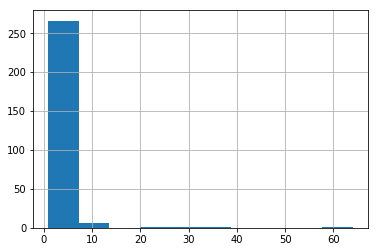

In [10]:
DB_numeric = DB[DB.columns.difference(['Country','All Languages'])]
DB_numeric.sum(axis=0).hist() ## how mant countries are speking this language

In [11]:
DB_numeric.sum(axis=0).sort_values(ascending = False)[:10]

English       64
French        34
Arabic        29
Spanish       23
German        12
Russian       11
Portuguese    11
Serbian       10
Romani         9
Italian        8
dtype: int64

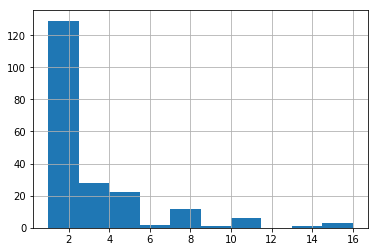

In [12]:
DB_numeric.sum(axis=1).hist() ## how mant languages are in a specific country

The matrix of distanses dis[i,j] will represent the distance between country[i] to country[j]

I think something is not wirking correctly in the Distance(.) function. After reading a bit, I discovered that the L2 norm is not working weel in a high dimentional spaces [http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.23.7409&rep=rep1&type=pdf]. Hence I will try to use cosine distance.

In [13]:
number_of_countries = DB.shape[0]
languags_array = DB.columns
countries_array = language_dataset['Country']
country2Ind = dict([(word,ind) for (ind,word) in enumerate(countries_array)])

def distance(np_arr1, dist_func=lambda i,j:
             1 - np.dot(i, j)/(np.linalg.norm(i)*np.linalg.norm(j)), mean=0.8): 
    if not isinstance(np_arr1, (np.ndarray, np.generic) ):
        np_arr = np_arr1[np_arr1.columns.difference(['Country','All Languages'])].to_numpy()
    else: 
        np_arr = np_arr1
    num = np_arr1.shape[0]
    number_of_countries = np_arr1.shape[0]
    dists = np.full((number_of_countries,number_of_countries), mean)
    
    for i in range(num):
        for j in range(num):
            if np.linalg.norm(np_arr[i]) == 0 or np.linalg.norm(np_arr[j]) == 0:
                dists[i][j] = mean
            else:
                dists[i][j] = dist_func(np_arr[i], np_arr[j])
    
    for country in ['Israel ', 'Russia ', 'United States ', 'Latvia ', 'Egypt ']:
        print('5 Closest countries to: %s' % country)
        country_dists = dists[list(countries_array).index(country)]
        i = 0
        for index in np.argsort(country_dists):
            if i < 4:
                print('\t#%d: %s,%f' % (i,list(countries_array)[index],country_dists[index]) + '\t', end='')
            i += 1
        print('\n5 Farest countries to: %s' % country)
        
        country_dists = dists[list(countries_array).index(country)]
        i = 0
        for index in reversed(np.argsort(country_dists)):
            if i < 4:
                print('\t#%d: %s,%f' % (i,list(countries_array)[index],country_dists[index]) + '\t', end='')
            i += 1
        print('\n')
    
    
    return dists

dist = distance(DB)

5 Closest countries to: Israel 
	#0: Israel ,0.000000		#1: Palestine ,0.133975		#2: Sudan ,0.292893		#3: Somaliland ,0.422650	
5 Farest countries to: Israel 
	#0: Guinea-Bissau ,1.000000		#1: Myanmar  ,1.000000		#2: Dominican Republic ,1.000000		#3: Nepal ,1.000000	

5 Closest countries to: Russia 
	#0: Russia ,0.000000		#1: Turkmenistan ,0.292893		#2: Tajikistan ,0.292893		#3: Belarus ,0.292893	
5 Farest countries to: Russia 
	#0: Zimbabwe ,1.000000		#1: Georgia ,1.000000		#2: Honduras ,1.000000		#3: Haiti ,1.000000	

5 Closest countries to: United States 
	#0: Zambia ,0.000000		#1: Barbados ,0.000000		#2: Gambia ,0.000000		#3: Liberia ,0.000000	
5 Farest countries to: United States 
	#0: Libya ,1.000000		#1: Guinea ,1.000000		#2: Ivory Coast ,1.000000		#3: Italy ,1.000000	

5 Closest countries to: Latvia 
	#0: Latvia ,0.000000		#1: Abkhazia ,1.000000		#2: Nicaragua ,1.000000		#3: Niger ,1.000000	
5 Farest countries to: Latvia 
	#0: Zimbabwe ,1.000000		#1: Gambia ,1.000000		#2: Haiti 

My matrics taking in account only the intersection between the sets of languages, this is  2 countries will be similar if and only if they share alot of languages. I what to capture the similarity between languages, for example I want to make my matrics capture the fact the two countries in which the spoken languages are Spanish in one and French in the other, will be similar. This will be done by changing a bit the hot_vectors: for each country with hot_vectors[i]=1, I will mark each language j that is "similar" to language i by changing the entry hot_vectors[j] to be 1/2. The number 1/2 is somewhat random, but for now I think it will capture the difference between speakning the same language and speaking a related language. The next step is to find t classification of the languages into similarity classes.

### Classification of languags

In [14]:
langs_genus = pd.DataFrame(columns=['Lang','Genus'])
with open(os.getcwd() + '/data/languages_classi.txt') as file:
    for line in file:
        lis = line.split('\t')
        new_row = {'Lang':lis[2],'Genus':lis[6]}
        langs_genus = langs_genus.append(new_row, ignore_index=True)
# for index, row in hot_vectors.iterrows():
#    print(row)

In [15]:
langs_genus = langs_genus[1:]
langs_genus.head()

,Lang,Genus
1,Engenni,Edoid
2,Banoni,Oceanic
3,Arandai,South Bird's Head Proper
4,Kotoko,Biu-Mandara
5,Kiliwa,Yuman


In [16]:
sorted_genus = langs_genus.groupby("Genus").count().sort_values('Lang',ascending = False)
most_pop = sorted_genus[:10]
all_other = pd.DataFrame({'Lang':sorted_genus[10:].sum()})
most_pop = pd.concat([most_pop,all_other])

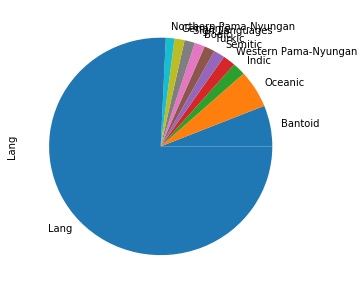

In [17]:
most_pop.plot.pie(y='Lang',legend=False,figsize=(5, 5))

In [18]:
#genus = langs_genus[pd.notnull(langs_genus['Genus'])].set_index('Genus')
genus_to_langs = langs_genus.set_index('Genus').groupby('Genus')['Lang'].transform(lambda x: '_'.join(x)).reset_index()
genus_to_langs['Lang'] = genus_to_langs['Lang'].apply(lambda x: x.split('_'))
genus_to_langs = genus_to_langs.drop_duplicates(subset='Genus')
genus_to_langs.head()

,Genus,Lang
0,Edoid,"[Engenni, Bini, Etsako, Degema, Isoko, Urhobo,..."
1,Oceanic,"[Banoni, Manam, Pileni, Natügu, 'Are'are, Raga..."
2,South Bird's Head Proper,[Arandai]
3,Biu-Mandara,"[Kotoko, Daba, Lamang, Lagwan, Musgu, Gude, Ga..."
4,Yuman,"[Kiliwa, Mojave, Hualapai, Diegueño (Mesa Gran..."


### Combine the Genus with the languages
In this stage, I will iterate through the one-hot vectors of the language, and add the additional information about the genus of the languages

In [19]:
def add_genus_scores(hot_vectors):
    hot_vectors = hot_vectors.copy()
    for index, row in hot_vectors.iterrows():
        country = countries_array[index]
        all_languages = row['All Languages']
        all_sim_langs = []
        for language in all_languages:
            if language != '':
                my_regex = r'.*?' + re.escape(language) + r".*?"
                if langs_genus['Lang'].str.contains(my_regex).any():
                    to_add = langs_genus.loc[langs_genus['Lang'].str.contains(my_regex) > 0]
                    for new_genus in list(to_add['Genus'].values):
                        all_sim_langs += genus_to_langs.loc[genus_to_langs['Genus'] == new_genus].Lang.values[0]
        all_sim_langs = [re.sub('\(.*\)', '', language) for language in list(dict.fromkeys(all_sim_langs))]
        for langu in all_sim_langs:
            for lang in langu.split(' '): 
                if lang in languags_array and lang not in all_languages:
                    hot_vectors.loc[index,lang] = 0.5
    return hot_vectors

In [20]:
DB_genus = add_genus_scores(DB)
DB_genus.head()

,Portuguese,Arabic 2%,Armenian recognized,Balochi 2%,Egyptian Arabic,Egyptian Language,"English, Maltese",Fiji Hindi,Guyanese Creole,Haitian Creole,...,Wolof,Xhosa,Yakan,Yiddish,Yoruba,Zande,Zarma,Zulu,name=Eswatini,All Languages
0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,"[Abkhaz, Russian, Georgian]"
1,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,"[Dari, Uzbek, Turkmen, Pashai, Nuristani, Balo..."
2,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,"[Albanian, Greek, Macedonian, Aromanian, Italian]"
3,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,"[Tamazight, Arabic, French]"
4,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,"[Catalan, Spanish, French, Portuguese]"


In [21]:
dists = distance(DB_genus)

5 Closest countries to: Israel 
	#0: Israel ,0.000000		#1: Russia ,0.201931		#2: Poland ,0.229402		#3: Belarus ,0.246303	
5 Farest countries to: Israel 
	#0: Kazakhstan ,1.000000		#1: Malaysia ,1.000000		#2: Kyrgyzstan ,1.000000		#3: Bolivia ,1.000000	

5 Closest countries to: Russia 
	#0: Russia ,0.000000		#1: Belarus ,0.055600		#2: Transnistria ,0.064181		#3: South Ossetia ,0.102850	
5 Farest countries to: Russia 
	#0: Libya ,1.000000		#1: Saudi Arabia ,1.000000		#2: China ,1.000000		#3: Malta ,1.000000	

5 Closest countries to: United States 
	#0: Saint Lucia ,0.000000		#1: Sierra Leone ,0.000000		#2: Saint Vincent and the Grenadines ,0.000000		#3: Saint Kitts and Nevis ,0.000000	
5 Farest countries to: United States 
	#0: Libya ,1.000000		#1: Northern Cyprus ,1.000000		#2: China ,1.000000		#3: Somalia ,1.000000	

5 Closest countries to: Latvia 
	#0: Latvia ,0.000000		#1: Lithuania ,0.538120		#2: Niger ,1.000000		#3: Nigeria ,1.000000	
5 Farest countries to: Latvia 
	#0: Zimbabwe ,1

One problem that I see here is that some languages (for example Russian) has alot of languages in their Genus, and thus creates a bais. In order to deal with it, I will normlize it.

In [22]:
def add_genus_scores_normlized(hot_vectors):
    hot_vectors = hot_vectors.copy()
    for index, row in hot_vectors.iterrows():
        all_languages = row['All Languages']
        for language in all_languages:
            sim_langs_to_add = []
            if language != '':
                my_regex = r'.*?' + re.escape(language) + r".*?"
                if langs_genus['Lang'].str.contains(my_regex).any():
                    to_add = langs_genus.loc[langs_genus['Lang'].str.contains(my_regex) > 0]
                    for new_genus in list(to_add['Genus'].values):
                        sim_langs_to_add += genus_to_langs.loc[genus_to_langs['Genus'] == new_genus].Lang.values[0]
                    sim_langs_to_add = [re.sub(' \(.*\)', '', language) for language in sim_langs_to_add]
                    sim_langs_to_add = list(dict.fromkeys(sim_langs_to_add))
                    for langu in sim_langs_to_add:
                        for lang in langu.split(' '): 
                            if lang in languags_array and lang not in all_languages:
                                hot_vectors.loc[index,lang] = 1/(len(sim_langs_to_add))
    return hot_vectors

In [23]:
DB_genus = add_genus_scores_normlized(DB)
DB_genus.head()

,Portuguese,Arabic 2%,Armenian recognized,Balochi 2%,Egyptian Arabic,Egyptian Language,"English, Maltese",Fiji Hindi,Guyanese Creole,Haitian Creole,...,Wolof,Xhosa,Yakan,Yiddish,Yoruba,Zande,Zarma,Zulu,name=Eswatini,All Languages
0,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,"[Abkhaz, Russian, Georgian]"
1,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,"[Dari, Uzbek, Turkmen, Pashai, Nuristani, Balo..."
2,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,"[Albanian, Greek, Macedonian, Aromanian, Italian]"
3,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,"[Tamazight, Arabic, French]"
4,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,"[Catalan, Spanish, French, Portuguese]"


In [24]:
lang_dists = distance(DB_genus)

5 Closest countries to: Israel 
	#0: Israel ,0.000000		#1: Palestine ,0.133475		#2: Sudan ,0.272466		#3: Somaliland ,0.405905	
5 Farest countries to: Israel 
	#0: Latvia ,1.000000		#1: Bhutan ,1.000000		#2: Taiwan ,1.000000		#3: Kazakhstan ,1.000000	

5 Closest countries to: Russia 
	#0: Russia ,0.000000		#1: Belarus ,0.292571		#2: Turkmenistan ,0.293578		#3: Tajikistan ,0.293699	
5 Farest countries to: Russia 
	#0: Libya ,1.000000		#1: Kuwait ,1.000000		#2: Syria ,1.000000		#3: Oman ,1.000000	

5 Closest countries to: United States 
	#0: Saint Vincent and the Grenadines ,0.000000		#1: Saint Kitts and Nevis ,0.000000		#2: Sierra Leone ,0.000000		#3: Grenada ,0.000000	
5 Farest countries to: United States 
	#0: Libya ,1.000000		#1: Northern Cyprus ,1.000000		#2: Somalia ,1.000000		#3: Egypt ,1.000000	

5 Closest countries to: Latvia 
	#0: Latvia ,0.000000		#1: Lithuania ,0.507358		#2: Niger ,1.000000		#3: Nigeria ,1.000000	
5 Farest countries to: Latvia 
	#0: Zimbabwe ,1.000000		#1: Gam

I am happy with this result. Lets move to the religion data.

## Religion

Data was downloaded from https://correlatesofwar.org.

In [25]:
country_religion = pd.read_csv(os.getcwd()+'/data/WRP_national.csv')
country_religion.head()

,year,state,name,chrstprot,chrstcat,chrstorth,chrstang,chrstothr,chrstgen,judorth,...,othrgenpct,sumreligpct,total,dualrelig,datatype,sourcereliab,recreliab,reliabilevel,Version,sourcecode
0,1945,2,USA,66069671,38716742,1121898,2400000,1956807,110265118,821489,...,0.0039,0.9961,1.0000,0,34,2,10,Medium,1.1,13
1,1950,2,USA,73090083,42635882,3045420,3045420,1177214,122994019,1078078,...,0.0041,0.9959,1.0000,0,34,6,28,Low,1.1,18
2,1955,2,USA,79294628,46402368,3454916,2572767,2277091,134001770,944000,...,0.0193,0.9807,0.9999,0,134,5,10,Medium,1.1,15
3,1960,2,USA,90692928,50587880,3334535,2710065,2908939,150234347,973500,...,0.0076,0.9924,0.9999,0,134,2,10,Medium,1.1,13
4,1965,2,USA,94165803,64761783,4792868,2822149,973155,167515758,991200,...,0.0030,0.9970,1.0001,0,134,8,28,Low,1.1,20


In [26]:
country_religion.columns

Index(['year', 'state', 'name', 'chrstprot', 'chrstcat', 'chrstorth',
       'chrstang', 'chrstothr', 'chrstgen', 'judorth', 'jdcons', 'judref',
       'judothr', 'judgen', 'islmsun', 'islmshi', 'islmibd', 'islmnat',
       'islmalw', 'islmahm', 'islmothr', 'islmgen', 'budmah', 'budthr',
       'budothr', 'budgen', 'zorogen', 'hindgen', 'sikhgen', 'shntgen',
       'bahgen', 'taogen', 'jaingen', 'confgen', 'syncgen', 'anmgen',
       'nonrelig', 'othrgen', 'sumrelig', 'pop', 'chrstprotpct', 'chrstcatpct',
       'chrstorthpct', 'chrstangpct', 'chrstothrpct', 'chrstgenpct',
       'judorthpct', 'judconspct', 'judrefpct', 'judothrpct', 'judgenpct',
       'islmsunpct', 'islmshipct', 'islmibdpct', 'islmnatpct', 'islmalwpct',
       'islmahmpct', 'islmothrpct', 'islmgenpct', 'budmahpct', 'budthrpct',
       'budothrpct', 'budgenpct', 'zorogenpct', 'hindgenpct', 'sikhgenpct',
       'shntgenpct', 'bahgenpct', 'taogenpct', 'jaingenpct', 'confgenpct',
       'syncgenpct', 'anmgenpct', 'nonrel

In [27]:
rel_list = ['chrstprotpct', 'chrstcatpct','chrstorthpct', 'chrstangpct', 'chrstothrpct', 'chrstgenpct',
            'judorthpct', 'judconspct', 'judrefpct', 'judothrpct', 'judgenpct',
            'islmsunpct', 'islmshipct', 'islmibdpct', 'islmnatpct', 'islmalwpct',
            'islmahmpct', 'islmothrpct', 'islmgenpct', 'budmahpct', 'budthrpct',
            'budothrpct', 'budgenpct', 'zorogenpct', 'hindgenpct', 'sikhgenpct',
            'shntgenpct', 'bahgenpct', 'taogenpct', 'jaingenpct', 'confgenpct',
            'syncgenpct', 'anmgenpct', 'nonreligpct', 'othrgenpct',]
country_religion = country_religion.loc[country_religion['year'] == 2010][rel_list+['name']]
country_religion.head()

,chrstprotpct,chrstcatpct,chrstorthpct,chrstangpct,chrstothrpct,chrstgenpct,judorthpct,judconspct,judrefpct,judothrpct,...,shntgenpct,bahgenpct,taogenpct,jaingenpct,confgenpct,syncgenpct,anmgenpct,nonreligpct,othrgenpct,name
13,0.3829,0.2507,0.0225,0.0155,0.0738,0.7454,0.0034,0.0056,0.0078,0.0023,...,0.0005,0.0015,0.0000,0.0003,0.0003,0.0026,0.0057,0.1900,0.0025,USA
27,0.2298,0.4202,0.0228,0.0789,0.0144,0.7661,0.0020,0.0035,0.0015,0.0030,...,0.0000,0.0005,0.0001,0.0001,0.0001,0.0008,0.0021,0.1643,0.0010,CAN
35,0.6760,0.1400,0.0000,0.1500,0.0000,0.9660,0.0000,0.0000,0.0000,0.0010,...,0.0000,0.0000,0.0003,0.0000,0.0000,0.0000,0.0032,0.0290,0.0005,BHM
49,0.0489,0.6000,0.0000,0.0000,0.0100,0.6589,0.0000,0.0000,0.0000,0.0001,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.0000,0.1315,0.0000,CUB
63,0.1000,0.7200,0.0000,0.0000,0.0000,0.8200,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0009,0.0000,0.0000,0.0000,0.4500,0.0000,0.1000,0.0000,HAI


In [28]:
country_code = pd.read_csv(os.getcwd()+'/data/COW_country_codes.csv')
country_code.head()

,StateAbb,CCode,StateNme
0,USA,2,United States
1,CAN,20,Canada
2,BHM,31,Bahamas
3,CUB,40,Cuba
4,CUB,40,Cuba


In [29]:
country_religion = pd.merge(country_religion, country_code, left_on='name', right_on='StateAbb').drop_duplicates() 
country_religion.head()

,chrstprotpct,chrstcatpct,chrstorthpct,chrstangpct,chrstothrpct,chrstgenpct,judorthpct,judconspct,judrefpct,judothrpct,...,jaingenpct,confgenpct,syncgenpct,anmgenpct,nonreligpct,othrgenpct,name,StateAbb,CCode,StateNme
0,0.3829,0.2507,0.0225,0.0155,0.0738,0.7454,0.0034,0.0056,0.0078,0.0023,...,0.0003,0.0003,0.0026,0.0057,0.1900,0.0025,USA,USA,2,United States
1,0.2298,0.4202,0.0228,0.0789,0.0144,0.7661,0.0020,0.0035,0.0015,0.0030,...,0.0001,0.0001,0.0008,0.0021,0.1643,0.0010,CAN,CAN,20,Canada
2,0.6760,0.1400,0.0000,0.1500,0.0000,0.9660,0.0000,0.0000,0.0000,0.0010,...,0.0000,0.0000,0.0000,0.0032,0.0290,0.0005,BHM,BHM,31,Bahamas
3,0.0489,0.6000,0.0000,0.0000,0.0100,0.6589,0.0000,0.0000,0.0000,0.0001,...,0.0000,0.0000,0.5000,0.0000,0.1315,0.0000,CUB,CUB,40,Cuba
5,0.1000,0.7200,0.0000,0.0000,0.0000,0.8200,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.4500,0.0000,0.1000,0.0000,HAI,HAI,41,Haiti


In [30]:
def rel_df(hot_vectors1):
    no_relison_data = []
    new_df = pd.DataFrame(columns=rel_list)
    for index, row in hot_vectors1.iterrows():
        country = countries_array[index]
        country = country[:len(country)-1]
        country_row = country_religion[country_religion['StateNme'] == country]
        new_cols = {'Country':country+' '}

        if not country_row.empty:
            country_row = country_row[country_row.columns.difference(['CCode','StateNme','StateAbb'])]
        else:
            no_relison_data.append(country)
            country_row = pd.DataFrame(columns=rel_list+['Country'])
            for rel in rel_list:
                country_row[rel] = 0

        for rel in rel_list:
                val = country_row[rel].values
                if len(val) > 0:
                    val = val[0]
                else:
                    val = 0
                new_cols[rel] = val
        new_df = new_df.append(new_cols, ignore_index=True)
    print('No religion for the following countries:'+ str(no_relison_data))
    return new_df

DB_rel = rel_df(DB_genus)
DB_rel.head()

No religion for the following countries:['Abkhazia', 'Antigua and Barbuda', 'Artsakh', 'Democratic Republic of the Congo', 'Eswatin', 'Sovereign Military Order of Malta', 'Myanmar ', 'North Macedonia', 'Northern Cyprus', 'Palestine', 'Sahrawi Arab Democratic Republic', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'São Tomé and Príncipe', 'Serbia', 'Somaliland', 'South Ossetia', 'South Sudan', 'Transnistria', 'Vatican City']


,chrstprotpct,chrstcatpct,chrstorthpct,chrstangpct,chrstothrpct,chrstgenpct,judorthpct,judconspct,judrefpct,judothrpct,...,shntgenpct,bahgenpct,taogenpct,jaingenpct,confgenpct,syncgenpct,anmgenpct,nonreligpct,othrgenpct,Country
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abkhazia
1,0.0002,0,0,0,0,0.0003,0,0,0,0,...,0,0.0001,0,0,0,0,0.0001,0.002,0.0014,Afghanistan
2,0,0.1313,0.07,0,0.0131,0.2144,0,0,0,0,...,0,0.0022,0,0,0,0,0,0.1507,0.0027,Albania
3,0,0,0,0,0.008,0.008,0,0,0,0,...,0,0,0,0,0,0,0,0,0.002,Algeria
4,0.0035,0.8544,0,0,0.049,0.907,0,0,0,0,...,0,0,0,0,0,0,0,0.0796,0.0009,Andorra


In [31]:
rel_dists = distance(DB_rel)

5 Closest countries to: Israel 
	#0: Israel ,0.000000		#1: Kyrgyzstan ,0.745993		#2: Tajikistan ,0.746438		#3: Uzbekistan ,0.746480	
5 Farest countries to: Israel 
	#0: Bhutan ,0.997936		#1: Japan ,0.996298		#2: Laos ,0.995758		#3: Cambodia ,0.994959	

5 Closest countries to: Russia 
	#0: Russia ,0.000000		#1: Georgia ,0.002061		#2: Bulgaria ,0.004404		#3: Moldova ,0.006533	
5 Farest countries to: Russia 
	#0: Cambodia ,0.994721		#1: Bhutan ,0.991397		#2: Laos ,0.985612		#3: Nepal ,0.981698	

5 Closest countries to: United States 
	#0: United States ,0.000000		#1: Germany ,0.009571		#2: Latvia ,0.022216		#3: Namibia ,0.024344	
5 Farest countries to: United States 
	#0: Comoros ,0.990584		#1: Iran ,0.989604		#2: Cambodia ,0.987584		#3: Yemen ,0.987400	

5 Closest countries to: Latvia 
	#0: Latvia ,0.000000		#1: United States ,0.022216		#2: Germany ,0.030300		#3: Canada ,0.049542	
5 Farest countries to: Latvia 
	#0: Yemen ,0.999812		#1: Kuwait ,0.999627		#2: Somalia ,0.999394		#3: Afghan

### Median Salary

In [32]:
country_salary = pd.read_csv(os.getcwd()+'/data/salary.csv')
country_salary.head()

,name,medianHouseholdIncome,medianPerCapitaIncome,pop2020
0,Luxembourg,52493,18418,625.978
1,Norway,51489,19308,5421.241
2,Sweden,50514,18632,10099.265
3,Australia,46555,15026,25499.884
4,Denmark,44360,18262,5792.202


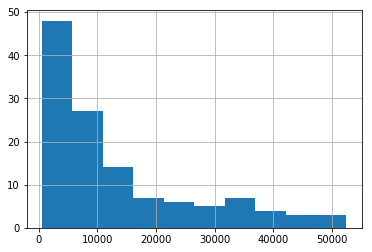

In [33]:
country_salary['medianHouseholdIncome'].hist()

In [34]:
def create_DB_from_CSV(basic_DB, new_DB, new_column_name, old_column_name, old_country_column):
    new_df = pd.DataFrame(columns=[new_column_name])
    mean = new_DB[old_column_name].mean()
    std = new_DB[old_column_name].std()
    for index, row in basic_DB.iterrows():
        country = countries_array[index]
        country = country[:len(country)-1]
        country_row = new_DB[new_DB[old_country_column] == country]
        val = country_row[old_column_name].values
        if val.size > 0:
            val = (val[0] - mean) / std
        else:
            val = 0
        new_cols = {'Country':country+' ', new_column_name: val}
        new_df = new_df.append(new_cols, ignore_index=True)
    return new_df, mean, std

DB_sel, sel_mean, sel_std = create_DB_from_CSV(DB_genus, country_salary, 'median_income',
                                               'medianHouseholdIncome', 'name')

In [35]:
DB_sel.head()

,median_income,Country
0,0,Abkhazia
1,-0.677769,Afghanistan
2,-0.437536,Albania
3,-0.397283,Algeria
4,0,Andorra


In [36]:
dists_sel = distance(DB_sel, dist_func=lambda i,j: np.linalg.norm(i-j), mean=1.6)

5 Closest countries to: Israel 
	#0: Israel ,0.000000		#1: France ,0.056278		#2: United Kingdom ,0.094273		#3: Singapore ,0.150174	
5 Farest countries to: Israel 
	#0: Togo ,2.241556		#1: Burundi ,2.233881		#2: Liberia ,2.225756		#3: Madagascar ,2.208301	

5 Closest countries to: Russia 
	#0: Russia ,0.000000		#1: Mexico ,0.003310		#2: Montenegro ,0.015424		#3: Azerbaijan ,0.020916	
5 Farest countries to: Russia 
	#0: Luxembourg ,3.067364		#1: Norway ,2.991826		#2: Sweden ,2.918469		#3: Australia ,2.620603	

5 Closest countries to: United States 
	#0: United States ,0.000000		#1: Denmark ,0.058309		#2: Canada ,0.173423		#3: South Korea ,0.204947	
5 Farest countries to: United States 
	#0: Togo ,3.236273		#1: Burundi ,3.228599		#2: Liberia ,3.220473		#3: Madagascar ,3.203018	

5 Closest countries to: Latvia 
	#0: Latvia ,0.000000		#1: Ukraine ,0.046121		#2: Malaysia ,0.056127		#3: Azerbaijan ,0.074109	
5 Farest countries to: Latvia 
	#0: Luxembourg ,3.162390		#1: Norway ,3.086851		#2: S

## Median age
Data was downloaded from https://apps.who.int/gho/data/view.main.POP2040?lang=en

In [37]:
country_age = pd.read_csv(os.getcwd()+'/data/age.csv')
country_age.head()

,Unnamed: 0,Population median age (years),Population living on <$1 (PPP int. $) a day (%)
0,Country,2013.0,2007-2013
1,Afghanistan,16.5,NaN
2,Albania,32.9,<2.0
3,Algeria,26.9,NaN
4,Angola,16.3,43.4


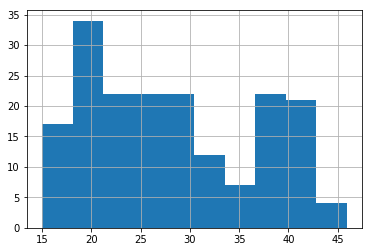

In [38]:
country_age['Population median age (years)'][1:].hist()

In [39]:
DB_age, age_mean, age_std = create_DB_from_CSV(DB_genus, country_age, 'median_age',
                                               'Population median age (years)', 'Unnamed: 0')

DB_age.head()

,median_age,Country
0,0,Abkhazia
1,-0.153621,Afghanistan
2,-0.0417266,Albania
3,-0.0826634,Algeria
4,0,Andorra


In [40]:
dists_age = distance(DB_age, dist_func=lambda i,j: np.linalg.norm(i-j), mean=0.01)

5 Closest countries to: Israel 
	#0: Israel ,0.000000		#1: Bahrain ,0.000000		#2: United Arab Emirates ,0.000682		#3: Brazil ,0.001365	
5 Farest countries to: Israel 
	#0: Japan ,0.107800		#1: Germany ,0.105071		#2: Niger ,0.103024		#3: Chad ,0.097566	

5 Closest countries to: Russia 
	#0: Abkhazia ,0.010000		#1: Niger ,0.010000		#2: Nigeria ,0.010000		#3: North Macedonia ,0.010000	
5 Farest countries to: Russia 
	#0: Zimbabwe ,0.010000		#1: Gambia ,0.010000		#2: Haiti ,0.010000		#3: Guyana ,0.010000	

5 Closest countries to: United States 
	#0: Abkhazia ,0.010000		#1: Niger ,0.010000		#2: Nigeria ,0.010000		#3: North Macedonia ,0.010000	
5 Farest countries to: United States 
	#0: Zimbabwe ,0.010000		#1: Gambia ,0.010000		#2: Haiti ,0.010000		#3: Guyana ,0.010000	

5 Closest countries to: Latvia 
	#0: Latvia ,0.000000		#1: Belgium ,0.000682		#2: Spain ,0.000682		#3: Netherlands ,0.002047	
5 Farest countries to: Latvia 
	#0: Niger ,0.180804		#1: Chad ,0.175346		#2: Uganda ,0.175346		#3:

## Visualisation

Running Truncated SVD over 204 words...
Done.
Running Truncated SVD over 204 words...
Done.
Running Truncated SVD over 204 words...
Done.
Running Truncated SVD over 204 words...
Done.
Running Truncated SVD over 204 words...
Done.
Plotting for the countries: ['Myanmar  ', 'Tuvalu ', 'Egypt ', 'Slovenia ', 'Mexico ', 'South Ossetia ', 'Malta ', 'Indonesia ', 'Paraguay ', 'Bhutan ', 'Guyana ', 'Jamaica ', 'Senegal ', 'Armenia ', 'Sudan ', 'Palau ', 'Greece ', 'Angola ', 'Monaco ', 'Maldives ', 'Democratic Republic of the Congo ', 'Hungary ', 'Solomon Islands ', 'Bangladesh ', 'South Ossetia ', 'Colombia ', 'Gambia ', 'Vietnam ', 'Malawi ', 'Solomon Islands ', 'Brunei ', 'Singapore ', 'Belarus ', 'Federated States of Micronesia ', 'North Macedonia ', 'Slovenia ', 'Guatemala ', 'Lesotho ', 'Croatia ', 'Maldives ', 'Brazil ', 'Hungary ', 'Nauru ', 'Kiribati ', 'Greece ', 'Nicaragua ', 'Vietnam ', 'Saint Kitts and Nevis ', 'Tuvalu ', 'Bosnia and Herzegovina ', 'Liberia ', 'Bangladesh ', 'Thai

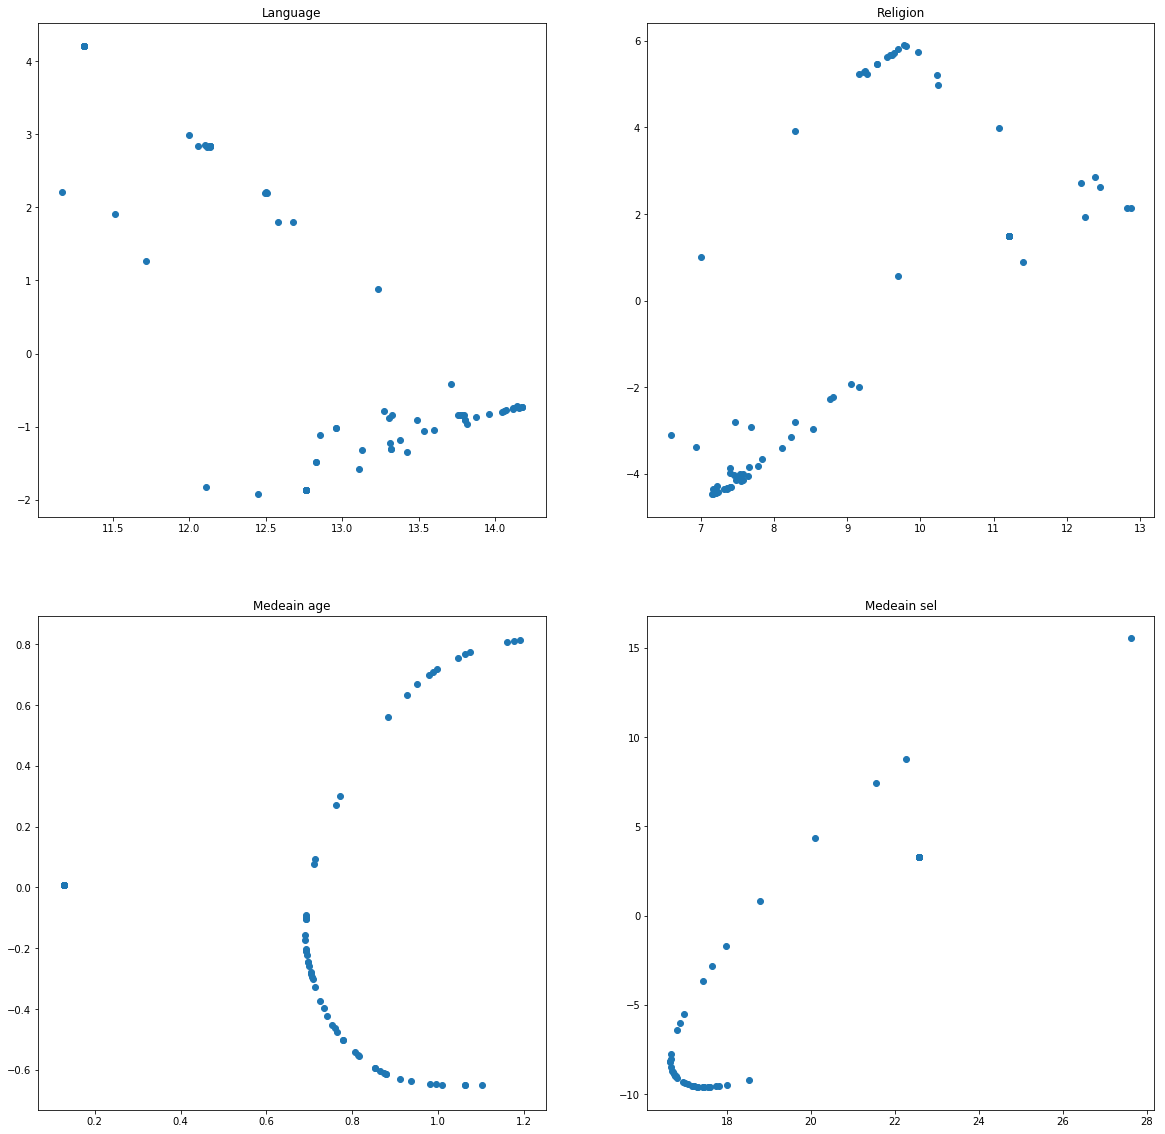

In [41]:
def reduce_dims_SVD(M, k=2, n_iters=10):
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    svd = decomposition.TruncatedSVD(k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    print("Done.")
    return M_reduced

def plot_embedding(list_of_dists, country2Ind, random_countries,lables=True):
    print('Plotting for the countries: '+str(random_countries))
    countries_ind = dict((country,ind) for (country,ind) in country2Ind.items() if country in random_countries)
    list_of_indices = [ind for (country,ind) in countries_ind.items()]
    fig = plt.figure(figsize=(20,20))
    spec = gridspec.GridSpec(ncols=int(len(list_of_dists)/2)+len(list_of_dists)%2, nrows=2)
    
    for i, dists in enumerate(list_of_dists):
        f2_ax1 = fig.add_subplot(spec[i])
        f2_ax1.title.set_text(dists[1])
        dists = dists[0]
        
        x = dists.T[0][list_of_indices]
        y = dists.T[1][list_of_indices]
        f2_ax1.scatter(x, y)

        i=0
        if lables:
            for (country, ind) in country2Ind.items():
                if ind in list_of_indices:
                    f2_ax1.annotate(country, (x[i], y[i]))
                    i += 1

reduced_langs = (reduce_dims_SVD(lang_dists),'Language')
reduced_rels = (reduce_dims_SVD(rel_dists),'Religion')
reduced_ages = (reduce_dims_SVD(dists_age),'Medeain age')
reduced_sels = (reduce_dims_SVD(dists_sel),'Medeain sel')

reduced_all = (reduce_dims_SVD(lang_dists + rel_dists + dists_age + dists_sel),'All')

random_countries = random.choices(countries_array, k=100)+['Israel ']
plot_embedding([reduced_langs, reduced_rels, reduced_ages, reduced_sels], country2Ind, random_countries,lables=False)

Plotting for the countries: ['Myanmar  ', 'Tuvalu ', 'Egypt ', 'Slovenia ', 'Mexico ', 'South Ossetia ', 'Malta ', 'Indonesia ', 'Paraguay ', 'Bhutan ', 'Guyana ', 'Jamaica ', 'Senegal ', 'Armenia ', 'Sudan ', 'Palau ', 'Greece ', 'Angola ', 'Monaco ', 'Maldives ', 'Democratic Republic of the Congo ', 'Hungary ', 'Solomon Islands ', 'Bangladesh ', 'South Ossetia ', 'Colombia ', 'Gambia ', 'Vietnam ', 'Malawi ', 'Solomon Islands ', 'Brunei ', 'Singapore ', 'Belarus ', 'Federated States of Micronesia ', 'North Macedonia ', 'Slovenia ', 'Guatemala ', 'Lesotho ', 'Croatia ', 'Maldives ', 'Brazil ', 'Hungary ', 'Nauru ', 'Kiribati ', 'Greece ', 'Nicaragua ', 'Vietnam ', 'Saint Kitts and Nevis ', 'Tuvalu ', 'Bosnia and Herzegovina ', 'Liberia ', 'Bangladesh ', 'Thailand ', 'Panama ', 'Maldives ', 'Nepal ', 'Dominican Republic ', 'Tajikistan ', 'Armenia ', 'Bangladesh ', 'Mongolia ', 'Mali ', 'Sierra Leone ', 'Grenada ', 'Cape Verde ', 'Serbia ', 'Marshall Islands ', 'India ', 'Venezuela ', '

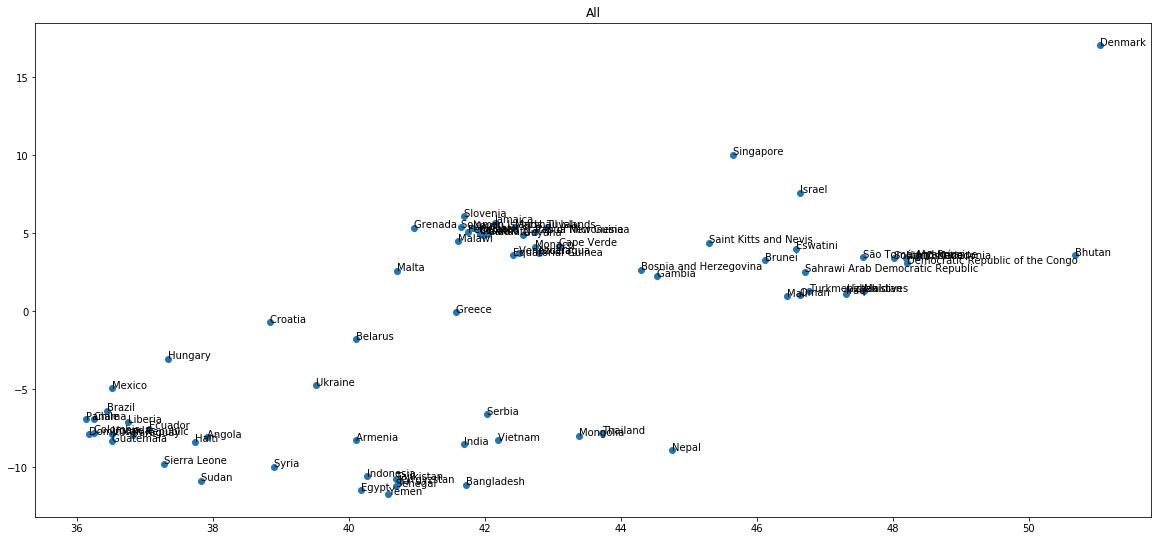

In [42]:
plot_embedding([reduced_all], country2Ind, random_countries)

## Dimentions Reduction
By now we have 314 features. This is a lot compared to the number of sampls we have (204). In this section, I will reduce the number of features. I will use the previous coine distance as the target function, and learn the embbeding in a method similar to word2vec algorithm.

Assume for each country we look at the top-k niebors in the previous modle. For each country i, let c_i, n_i be the vectors of the country i be the center and the neiberhood, respectively. The loos function will be the log of the cossim between each country to it's neibarhood, and we will try to minimize it by learning the representation.

In [43]:
%%latex
\begin{align}
\forall i\in{1,\dots N}, c_i,n_i\in \mathbb{R}^d
\end{align}

\begin{align}
L(\theta) = \log \prod_{i=1}^N \prod_{j=1}^K cossim(c_i,n_j) =
\sum_{i=1}^N \sum_{j=1}^K \log(cossim(c_i,n_j)) =  \sum_{i=1}^N \sum_{j=1}^K \log(\frac{c_in_j}{|c_i|\cdot|n_j|})
\end{align}

<IPython.core.display.Latex object>

Note the the only parameters here are the vectors. In order to minimize this loss function, we need to take it's gradient.

In [44]:
%%latex
\begin{align}
\nabla L \in \mathbb{R}^{2N}\times\mathbb{R}^d
\end{align}

<IPython.core.display.Latex object>

In [45]:
%%latex
\begin{align}
\nabla L = \begin{pmatrix}
                    \sum_{j=1}^K(\frac{n_{j1}}{c_1n_j}-\frac{c_{11}}{|c_1|^2})& \dots & \sum_{j=1}^K(\frac{n_{jN}}{c_Nn_j}-\frac{c_{1N}}{|c_1|^2})\\
                    \vdots & \vdots & \vdots \\
                    \sum_{j=1}^K(\frac{n_{j1}}{c_Nn_j}-\frac{c_{N1}}{|c_N|^2}) & \dots & \sum_{j=1}^K(\frac{n_{jN}}{c_Nn_j}-\frac{c_{NN}}{|c_N|^2})\\
                    \sum_{j=1}^N(\frac{c_{j1}}{n_1c_j}-\frac{n_{11}}{|n_1|^2}) & \dots & \sum_{j=1}^N(\frac{c_{jN}}{n_Nc_j}-\frac{n_{1N}}{|n_1|^2})\\
                    \vdots & \vdots & \vdots \\
                    \sum_{j=1}^N(\frac{c_{j1}}{n_Nc_j}-\frac{n_{N1}}{|n_N|^2}) & \dots & \sum_{j=1}^N(\frac{c_{jN}}{n_Nc_j}-\frac{n_{NN}}{|n_N|^2})
            \end{pmatrix} = 
            \begin{pmatrix}
                    \frac{1}{c_1}\sum_{j=1}^K(\frac{n_{j1}}{n_j})-K\frac{c_{11}}{|c_1|^2} & \dots & \frac{1}{c_1}\sum_{j=1}^K(\frac{n_{jN}}{n_j})-K\frac{c_{1N}}{|c_1|^2}\\
                    \vdots & \vdots & \vdots \\
                    \frac{1}{c_N}\sum_{j=1}^K(\frac{n_{j1}}{n_j})-K\frac{c_{N1}}{|c_N|^2} & \dots & \frac{1}{c_N}\sum_{j=1}^K(\frac{n_{jN}}{n_j})-K\frac{c_{NN}}{|c_N|^2}\\
                    \frac{1}{n_1}\sum_{j=1}^N(\frac{c_{j1}}{c_j})-N\frac{n_{11}}{|n_1|^2} & \dots & \frac{1}{n_1}\sum_{j=1}^N(\frac{c_{jN}}{c_j})-N\frac{n_{1N}}{|n_1|^2}\\
                    \vdots & \vdots & \vdots \\
                    \frac{1}{n_N}\sum_{j=1}^N(\frac{c_{j1}}{c_j})-N\frac{n_{N1}}{|n_N|^2} & \dots & \frac{1}{n_N}\sum_{j=1}^N(\frac{c_{jN}}{c_j})-N\frac{n_{NN}}{|n_N|^2}
            \end{pmatrix}
\end{align}

<IPython.core.display.Latex object>

The first N rows are for the c_is and the last N rows are for the n_is

In [46]:
def embedding(prev_vectors,num_of_closest_countries,  K=100, n_iter=50, 
              dist_func=lambda i,j: 1 - np.dot(i, j)/(np.linalg.norm(i)*np.linalg.norm(j)),
              learning_rate=10e-3,print_every=5):
    '''
    The likelihood function will be 
        L=-log(prod_i=0^num_of_countries prod_j=0^num_of_closest_countries cosine(country(i),country(j)))=
            -sum_num_of_countries(sum_num_of_colsest_countries(log(cosine(i,j))))
    
    Input: prev_vector: a numpy array with shape (number_of_vectors, number_of_feature)
            k: the new dimientions of each vector
            n_iter: the number of iteration to preform
            dists: the distances we calculated int he previous section. this will be used in the learning prosses.
    Output:
            vector_reduced: np array with dimentions (number_of_vector, k)
    '''
    num_of_contries = prev_vectors.shape[0]
    embeddings = np.random.rand(2*num_of_contries,K)
    print('Embedding %d vectors with %d features in a %d dimentions vector space.' % (num_of_contries,
                                                                                     prev_vectors.shape[1],
                                                                                     K))
    losses = []
    for it in range(0,n_iter):
        grad = np.zeros(embeddings.shape)
        loss = 0
        for i in range(0,num_of_contries):
            ci = embeddings[i]
            top_indices = np.argsort(prev_vectors[i])[1:num_of_closest_countries+1]
            for j in range(0,num_of_closest_countries):
                nj = embeddings[j + num_of_contries]
                loss += math.log(ci.dot(nj)/(np.linalg.norm(ci)*np.linalg.norm(nj)))
        losses.append(-loss)
        if it%print_every==0:
            print('Iter %d/%d: loss = %f.4' % (it,n_iter,losses[it]))
        for i in range(0,num_of_contries): ##c_i's
            ci = embeddings[i]
            for k in range(0,K):
                sum = 0
                top_indices = np.argsort(prev_vectors[i])[1:num_of_closest_countries+1]
                for j in range(0,num_of_closest_countries):
                    nj = embeddings[top_indices[j] + num_of_contries]
                    sum += (nj[k]/nj.dot(ci))
                grad[i,k] = sum-num_of_closest_countries*ci[k]/(np.linalg.norm(ci) **2 )
                
        for i in range(num_of_contries,2*num_of_contries): ##n_i's
            ni = embeddings[i]
            for k in range(0,K):
                sum = 0
                for j in range(0,num_of_contries):
                    cj = embeddings[j]
                    sum += (cj[k]/cj.dot(ni))
                grad[i,k] = sum-num_of_contries*ni[k]/(np.linalg.norm(ni) ** 2)
        embeddings -= -grad*learning_rate
    return embeddings, losses
                

Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/5: loss = 585.149895.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/5: loss = 589.803820.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/5: loss = 604.911185.4


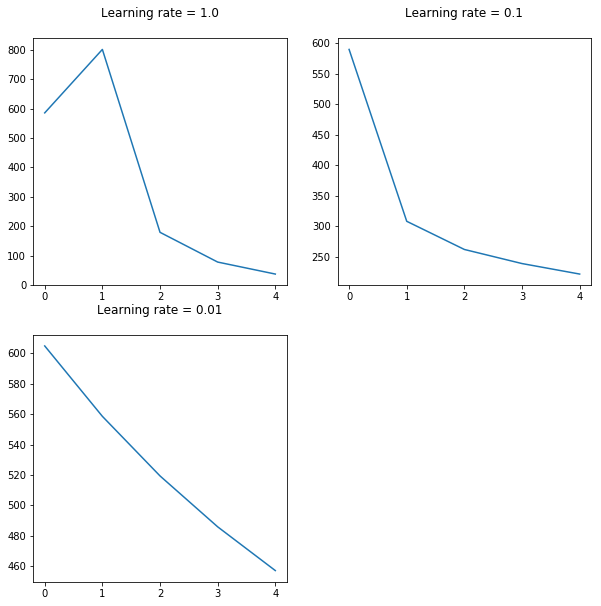

In [47]:
dists = lang_dists + rel_dists + dists_age + dists_sel
fig = plt.figure(figsize=(10,10))
spec = gridspec.GridSpec(ncols=2, nrows=2)

for i,lr in enumerate([10e-1,10e-2,10e-3]):    
    embedding_vec, losses = embedding(dists, 10, n_iter=5, learning_rate=lr)
    ax = fig.add_subplot(spec[i])
    ax.title.set_text('Learning rate = %s\n' % str(lr))
    ax.plot(losses)

Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 614.638896.4
Iter 5/6: loss = 223.201958.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 588.811897.4
Iter 5/6: loss = 109.327513.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 571.440022.4
Iter 5/6: loss = 53.893264.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 582.333630.4
Iter 5/6: loss = 28.362585.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 589.082883.4
Iter 5/6: loss = 20.209665.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 597.368518.4
Iter 5/6: loss = 26.136671.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 595.943276.4
Iter 5/6: loss = 41.336556.4
Embedding 204 vectors with 204 features in a 100 dimentions vector 

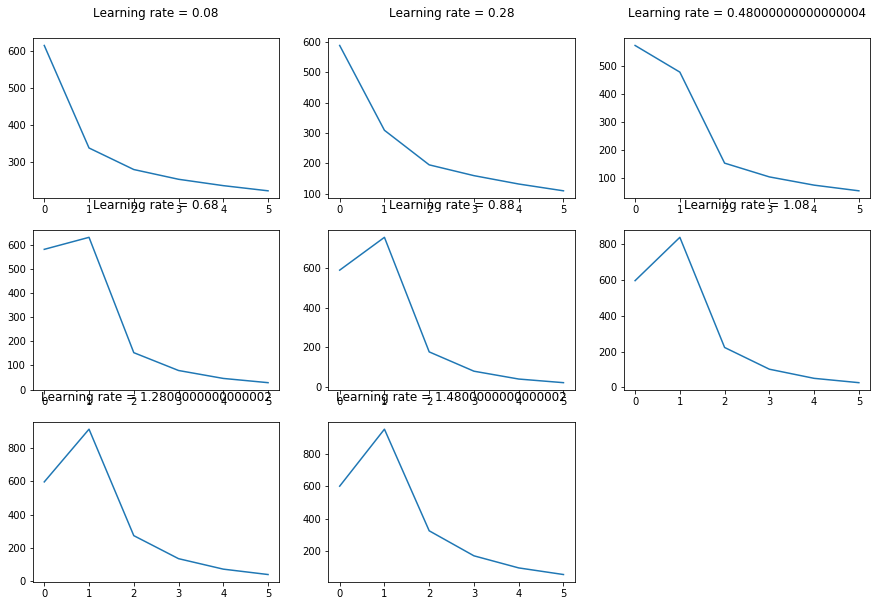

In [48]:
fig = plt.figure(figsize=(15,10))
spec = gridspec.GridSpec(ncols=3, nrows=3)
best_lr = 0
best_loss = 500

for i,lr in enumerate(np.arange(0.08,1.5,0.2)):
    embedding_vec, losses = embedding(dists, 10, n_iter=6, learning_rate=lr)
    if losses[::-1][0] < best_loss:
        best_loss = losses[::-1][0]
        best_lr = lr
    ax = fig.add_subplot(spec[i])
    ax.title.set_text('Learning rate = %s\n' % str(lr))
    ax.plot(losses)
print('Best learning rate %f.4' % best_lr)

Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/40: loss = 581.966576.4
Iter 10/40: loss = 1.169717.4
Iter 20/40: loss = 0.005090.4
Iter 30/40: loss = 0.000026.4


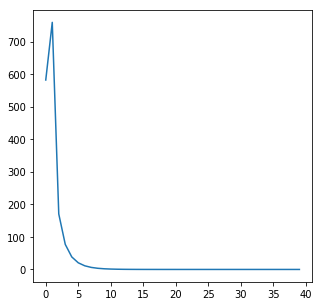

In [49]:
fig = plt.figure(figsize=(5,5))
spec = gridspec.GridSpec(ncols=1, nrows=1)

embedding_vec, losses = embedding(dists, 10, n_iter=40, print_every=10, learning_rate=best_lr)
ax = fig.add_subplot(spec[0])
ax.plot(losses)

In [50]:
print(embedding_vec[dists.shape[0]:2*dists.shape[0]])

[[2.02284978 2.1486996  2.0958612  ... 2.09425349 2.00720248 2.11445176]
 [2.0142261  2.13953942 2.08692627 ... 2.08532541 1.99864551 2.10543758]
 [1.88224511 1.99934733 1.95018165 ... 1.94868567 1.86768544 1.96748002]
 ...
 [2.03877004 2.16561033 2.11235607 ... 2.11073572 2.02299959 2.13109295]
 [2.09262745 2.22281846 2.16815736 ... 2.16649423 2.07644038 2.18738921]
 [1.77548479 1.88594501 1.839568   ... 1.83815686 1.76175095 1.85588521]]


There is a problem. My loss funciton is resulting in all the embeddings be the same. I need to add the farest countries as well. I will use the softmax instead.

In [51]:
%%latex
\begin{align}
L(\theta) = - 1/N \log \prod_{i=1}^N \prod_{j=1}^K softmax(c_i,n_j)= - \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^K \log \frac{exp(c_i\cdot n_j)}{\sum_{l=1}^N exp(c_i\cdot n_l)}
\end{align}

<IPython.core.display.Latex object>

In [52]:
%%latex
\begin{align}
\nabla L \in \mathbb{R}^{2N}\times\mathbb{R}^d
\\
\\
\\
\nabla L = \begin{pmatrix}
                    -\frac{1}{N}\sum_{j=1}^K( n_j- \sum_{r=1}^N softmax(c_1,n_r)\cdot n_r)\\
                    \vdots \\
                    -\frac{1}{N}\sum_{j=1}^K( n_j- \sum_{r=1}^N softmax(c_N,n_r)\cdot n_r)\\
                    -\frac{1}{N}\sum_{i=1}^N( c_i- \sum_{r=1}^N softmax(c_r,n_1)\cdot c_r)\\\
                    \vdots \\
                    -\frac{1}{N}\sum_{i=1}^N( c_i- \sum_{r=1}^N softmax(c_r,n_N)\cdot c_r)
                \end{pmatrix}
\end{align}

<IPython.core.display.Latex object>

In [53]:
def softmax(ci,nj,embbeings,num_of_countries,ci_flag):
    try:
        numinator = math.exp(ci.dot(nj.T))
    except OverflowError:
        numinator = float('inf')
    denuminator = 0
    if ci_flag:
        a = embbeings[num_of_countries:].dot(ci.T)
        b = np.exp(a)
        denuminator = np.sum(b)
    else:
        denuminator = np.sum(np.exp(embbeings[:num_of_countries].dot(nj)))
    if numinator/denuminator<=-1:
        print('!!')
    return numinator/denuminator

def embedding(prev_vectors,num_of_closest_countries,  K=100, n_iter=50, 
              dist_func=lambda i,j: 1 - np.dot(i, j)/(np.linalg.norm(i)*np.linalg.norm(j)),
              learning_rate=10e-3,print_every=5):
    '''
    The likelihood function will be 
        L=-log(prod_i=0^num_of_countries prod_j=0^num_of_closest_countries cosine(country(i),country(j)))=
            -sum_num_of_countries(sum_num_of_colsest_countries(log(cosine(i,j))))
    
    Input: prev_vector: a numpy array with shape (number_of_vectors, number_of_feature)
            K: the new dimientions of each vector
            n_iter: the number of iteration to preform
            dists: the distances we calculated int he previous section. this will be used in the learning prosses.
    Output:
            vector_reduced: np array with dimentions (number_of_vector, k)
    '''
    num_of_countries = prev_vectors.shape[0]
    embeddings = np.random.rand(2*num_of_countries,K)
    print('Embedding %d vectors with %d features in a %d dimentions vector space.' % (num_of_countries,
                                                                                     prev_vectors.shape[1],
                                                                                     K))
    losses = []
    for it in range(0,n_iter):
        grad = np.zeros(embeddings.shape)
        loss = 0
        for i in range(0,num_of_countries):
            ci = embeddings[i]
            top_indices = np.argsort(prev_vectors[i])[1:num_of_closest_countries+1]
            for j in range(0,num_of_closest_countries):
                nj = embeddings[j + num_of_countries]
                loss += math.log(softmax(ci,nj,embeddings,num_of_countries,True))
        losses.append(-1/(num_of_countries)*loss)
        if it%print_every==0:
            print('Iter %d/%d: loss = %f.4' % (it,n_iter,losses[it]))
        for i in range(0,num_of_countries): ##c_i's
            ci = embeddings[i]
            top_indices = np.argsort(prev_vectors[i])[1:num_of_closest_countries+1]
            sum1 = 0
            for j in range(0,num_of_closest_countries):
                nj = embeddings[top_indices[j] + num_of_countries]
                inner_sum = 0
                for r in range(0,num_of_countries):
                    nr = embeddings[r + num_of_countries]
                    inner_sum += softmax(ci,nr,embeddings,num_of_countries,True)*nr
                sum1 += nj - inner_sum
            grad[i] = -(1/num_of_countries)*sum1
        for i in range(num_of_countries,num_of_countries*2-1): ##nj's
            ni = embeddings[i]
            sum1 = 0
            random_countries = random.choices(range(0,num_of_countries),k=num_of_closest_countries)
            for j in random_countries:
                cj = embeddings[j]
                inner_sum = 0
                for r in range(0,num_of_countries):
                    cr = embeddings[r]
                    inner_sum += softmax(ni,cr,embeddings,num_of_countries,False)*cr
                sum1 += cj - inner_sum
            grad[i] = -(1/num_of_countries)*sum1
            
        embeddings -= grad*learning_rate
    return embeddings, losses

Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 67.261180.4
Iter 5/6: loss = 63.761766.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 65.843752.4
Iter 5/6: loss = 60.301429.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 69.063716.4
Iter 5/6: loss = 58.644474.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 56.870029.4
Iter 5/6: loss = 55.780511.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 69.977294.4
Iter 5/6: loss = 57.007569.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 62.925069.4
Iter 5/6: loss = 56.094740.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/6: loss = 67.854265.4
Iter 5/6: loss = 56.252945.4
Embedding 204 vectors with 204 features in a 100 dimentions vector space.
It

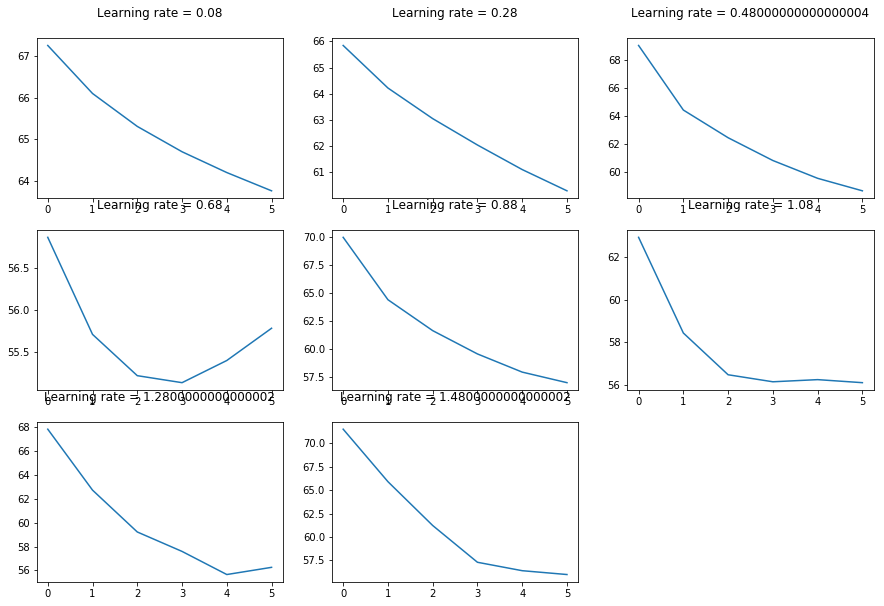

In [54]:
dists = lang_dists + rel_dists + dists_age + dists_sel

fig = plt.figure(figsize=(15,10))
spec = gridspec.GridSpec(ncols=3, nrows=3)
best_lr = 0
best_loss = 500

for i,lr in enumerate(np.arange(0.08,1.5,0.2)):
    embedding_vec, losses = embedding(dists, 10, n_iter=6, learning_rate=lr)
    if losses[::-1][0] < best_loss:
        best_loss = losses[::-1][0]
        best_lr = lr
    ax = fig.add_subplot(spec[i])
    ax.title.set_text('Learning rate = %s\n' % str(lr))
    ax.plot(losses)
print('Best learning rate %f.4' % best_lr)

Embedding 204 vectors with 204 features in a 100 dimentions vector space.
Iter 0/40: loss = 63.357605.4
Iter 10/40: loss = 56.159650.4
Iter 20/40: loss = 55.886975.4
Iter 30/40: loss = 55.537219.4


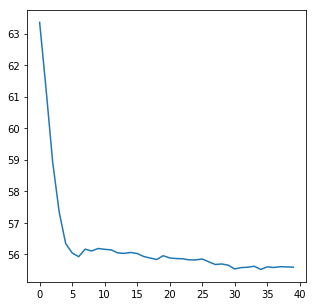

In [55]:
fig = plt.figure(figsize=(5,5))
spec = gridspec.GridSpec(ncols=1, nrows=1)

embedding_vec, losses = embedding(dists, 10, n_iter=40, print_every=10, learning_rate=best_lr)
ax = fig.add_subplot(spec[0])
ax.plot(losses)

In [56]:
embedding_vec_ci = embedding_vec[:int(embedding_vec.shape[0]/2)]

In [57]:
dists = distance(embedding_vec_ci)

5 Closest countries to: Israel 
	#0: Israel ,0.000000		#1: Panama ,0.173230		#2: El Salvador ,0.177965		#3: Palau ,0.180684	
5 Farest countries to: Israel 
	#0: Guyana ,0.330527		#1: Argentina ,0.307650		#2: Greece ,0.301455		#3: Indonesia ,0.301253	

5 Closest countries to: Russia 
	#0: Russia ,0.000000		#1: Saint Vincent and the Grenadines ,0.145839		#2: Egypt ,0.151249		#3: East Timor ,0.179934	
5 Farest countries to: Russia 
	#0: Fiji ,0.326260		#1: Guyana ,0.313702		#2: Republic of the Congo ,0.312321		#3: Suriname ,0.310261	

5 Closest countries to: United States 
	#0: United States ,0.000000		#1: Germany ,0.167146		#2: China ,0.178868		#3: Algeria ,0.181911	
5 Farest countries to: United States 
	#0: Indonesia ,0.326361		#1: Paraguay ,0.323266		#2: Kiribati ,0.321626		#3: Guinea ,0.321559	

5 Closest countries to: Latvia 
	#0: Latvia ,0.000000		#1: Saudi Arabia ,0.177585		#2: Montenegro ,0.180286		#3: Saint Vincent and the Grenadines ,0.187742	
5 Farest countries to: Latvia 
	#0

In [90]:
similar_countries_DF = pd.DataFrame(columns=['country'] + [str(i)+' close' for i in range(0,10)] + [str(i)+' far' for i in range(0,10)])

for country in countries_array:
    new_row = {}
    new_row['country'] = country[:len(country) - 1]
    country_dists = dists[list(countries_array).index(country)]
    i = 0
    for index in np.argsort(country_dists):
        if i < 11 and i > 0:
            new_country = list(countries_array)[index]
            new_row[str(i-1)+' close'] = new_country[:len(new_country) - 1]
        i += 1

    i = 0
    for index in reversed(np.argsort(country_dists)):
        if i < 10:
            new_country = list(countries_array)[index]
            new_row[str(i)+' far'] = new_country[:len(new_country) - 1]
        i += 1
    similar_countries_DF = similar_countries_DF.append(new_row, ignore_index=True)

similar_countries_DF = similar_countries_DF.set_index('country')
path = os.getcwd() + '/sim_countries.csv'
JSON = similar_countries_DF.to_json(orient='index')

In [91]:
with open(os.getcwd() + '/similar_countries_DF.txt', 'w') as output:
    output.write(JSON)